In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

In [2]:
df = pd.read_csv('flux.csv')

In [3]:
df.shape

(4180480, 10)

In [4]:
df.columns

Index(['date', 'basin_id', 'flux', 'precip', 'temp_max', 'gauge_name', 'lat',
       'lon', 'mean_elev', 'area_km2'],
      dtype='object')

In [5]:
df.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


In [6]:
df.describe().round(2)

,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2
count,4180480.00,4180480.00,4175037.00,4175037.00,4180480.00,4180480.00,4180480.00,4180480.00
mean,7179756.66,52.53,2.95,13.66,-35.70,-71.30,1760.13,2404.88
std,3180964.87,167.60,8.77,6.62,8.05,1.25,1382.12,4322.05
min,1001001.00,0.00,0.00,-11.60,-54.95,-73.67,118.12,17.89
25%,4558001.00,0.87,0.00,9.16,-39.15,-72.32,584.70,376.10
50%,7350003.00,5.17,0.00,13.21,-35.88,-71.37,1195.31,820.55
75%,9416001.00,29.90,0.64,18.06,-31.27,-70.51,3048.16,2461.61
max,12930001.00,15805.00,213.21,40.81,-17.84,-67.64,4910.15,52243.67


In [7]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2
basin_id,1.000000,0.218412,0.154384,0.024728,-0.972361,-0.715099,-0.839017,-0.081191
flux,0.218412,1.000000,0.157168,-0.065097,-0.180708,-0.258999,-0.172195,0.423227
precip,0.154384,0.157168,1.000000,-0.167713,-0.114745,-0.174026,-0.153925,-0.030863
temp_max,0.024728,-0.065097,-0.167713,1.000000,0.028275,-0.276995,-0.339706,0.049079
lat,-0.972361,-0.180708,-0.114745,0.028275,1.000000,0.621554,0.785535,0.081052
lon,-0.715099,-0.258999,-0.174026,-0.276995,0.621554,1.000000,0.818278,-0.022232
mean_elev,-0.839017,-0.172195,-0.153925,-0.339706,0.785535,0.818278,1.000000,0.048762
area_km2,-0.081191,0.423227,-0.030863,0.049079,0.081052,-0.022232,0.048762,1.000000


### Question 3a

In [8]:
from mizani.breaks import date_breaks

def custom_date_format(breaks):
    """
    Function to format the date
    """
    return [x.year if x.month==1 and x.day==1 else "" for x in breaks]

In [9]:
def plot_one_timeserie(cod_station, variable, min_date, max_date):
    
    df_temp = df[(df['date'] >= min_date) & (df['date'] <= max_date) & (df['basin_id'] == cod_station)]
    df_temp = df_temp[['date', variable]]
    
    p = (ggplot(data = df_temp, 
        mapping = aes(x = 'date', y = variable, group = 1)) + 
        geom_line() + 
        scale_x_datetime(breaks=date_breaks('1 month'),
                         labels=custom_date_format))
    
    return p

##### Testing function 'plot_one_timeserie'

In [10]:
# Initializing variables

cod_station = 1001001
variable = 'flux'
min_date = '1980-01-01'
max_date ='1981-05-01'

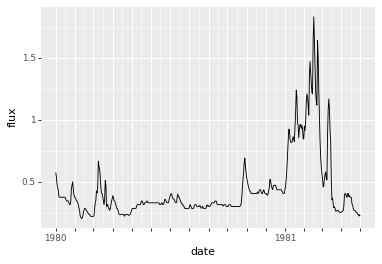

<ggplot: (157326342096)>

In [11]:
plot_one_timeserie(cod_station, variable, min_date, max_date)

### Question 3b

In [12]:
def plot_three_timeseries(cod_station, min_date, max_date):
    """
    Function to plot three variables for selected station
    Variables will be scaled with mean 0 and std 1
    """
    df_temp = df[(df['date'] >= min_date) & (df['date'] <= max_date) & (df['basin_id'] == cod_station)]
    df_temp2 = df_temp[['date', 'flux', 'precip', 'temp_max']]
    df_temp3 = df_temp2[['flux', 'precip', 'temp_max']]

    # Fitting standard scaler
    scaler = StandardScaler().fit_transform(df_temp3)
    df_temp4 = pd.DataFrame(scaler, columns = ['flux_scaled', 'precip_scaled', 'temp_max_scaled'])
    df_temp4['date'] = df_temp2['date']
    
    # Melting dataframe to plot
    df_melted = pd.melt(df_temp4, 
                        id_vars='date')
  
    p = (ggplot(data = df_melted, 
        mapping = aes(x = 'date', y = 'value', group = 'variable', color = 'variable')) + 
        geom_line() + 
        scale_x_datetime(breaks=date_breaks('1 month'),
                         labels=custom_date_format))
    
    return p

##### Testing function 'plot_three_timeseries'

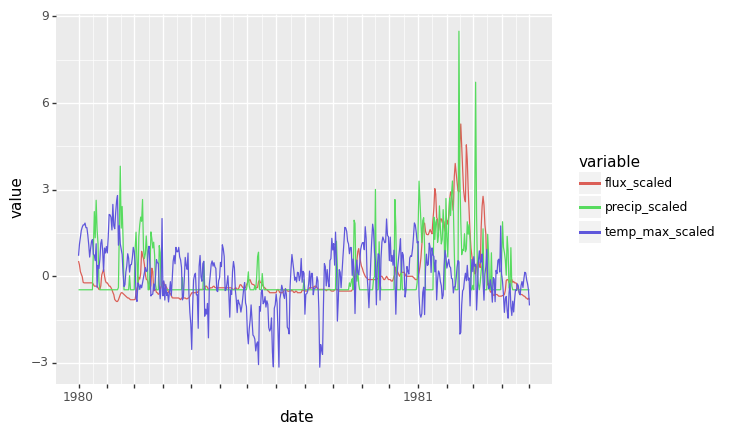

<ggplot: (157326442996)>

In [13]:
plot_three_timeseries(cod_station, min_date, max_date)

#### Question 4

In [14]:
# Defining seasons in Chile

from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('summer', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('autumn', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('winter', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('spring', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('summer', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)
    
print(get_season(date.today()))

winter


##### Applying function to all dates and creating a new columns 'season'

In [15]:
df['season'] = [get_season(datetime.strptime(x, '%Y-%m-%d').date()) for x in df['date'].values]

In [16]:
df['season']

0          summer
1          summer
2          summer
3          summer
4          summer
            ...  
4180475    autumn
4180476    autumn
4180477    autumn
4180478    autumn
4180479    autumn
Name: season, Length: 4180480, dtype: object

Detecting extreme values by the 95 percentile grouped by season is a good way to understand the seasonality of the variables since it can capture the changes through time. Another option more technically would be an analysis using anomally detection algorithms that detects seasonality on its own and its trends, since we have different behaviors with time. Using package 'Prophet' is a good way of doing this kind of detection. We're going to use it to modeling in the next sections.

In [17]:
extreme_temp = pd.DataFrame(df['temp_max'].groupby(df['season']).quantile([.95])).reset_index().rename(columns={"temp_max":"temp_extreme"})
extreme_flux = pd.DataFrame(df['flux'].groupby(df['season']).quantile([.95])).reset_index().rename(columns={"flux":"flux_extreme"})
extreme_precip = pd.DataFrame(df['precip'].groupby(df['season']).quantile([.95])).reset_index().rename(columns={"precip":"precip_extreme"})

extreme = pd.merge(extreme_temp,extreme_flux,how='left')
extreme = pd.merge(extreme,extreme_precip,how='left')
del extreme['level_1']

extreme

,season,temp_extreme,flux_extreme,precip_extreme
0,autumn,21.615697,223.0,24.752871
1,spring,24.301213,281.0,11.251434
2,summer,28.294681,162.0,7.393520
3,winter,17.060593,399.0,26.809024


In [18]:
df2 = pd.merge(df, extreme, how = 'left')
df2.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,season,temp_extreme,flux_extreme,precip_extreme
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352


In [19]:
# Creating flags for extreme events

df2['temp_extreme_flag'] = np.where(df2['temp_max'] > df2['temp_extreme'], 1, 0)
df2['flux_extreme_flag'] = np.where(df2['flux'] > df2['flux_extreme'], 1, 0)
df2['precip_flag'] = np.where(df2['precip'] > df2['temp_extreme'], 1, 0)
df2.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,season,temp_extreme,flux_extreme,precip_extreme,temp_extreme_flag,flux_extreme_flag,precip_flag
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352,0,0,0
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352,0,0,0
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352,0,0,0
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352,0,0,0
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.39352,0,0,0


#### Question 5

In [20]:
df2

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,season,temp_extreme,flux_extreme,precip_extreme,temp_extreme_flag,flux_extreme_flag,precip_flag
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.393520,0,0,0
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.393520,0,0,0
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.393520,0,0,0
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.393520,0,0,0
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,summer,28.294681,162.0,7.393520,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180475,2020-06-02,12930001,0.375,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,autumn,21.615697,223.0,24.752871,0,0,0
4180476,2020-06-03,12930001,0.342,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,autumn,21.615697,223.0,24.752871,0,0,0
4180477,2020-06-04,12930001,0.325,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,autumn,21.615697,223.0,24.752871,0,0,0
4180478,2020-06-05,12930001,0.311,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,autumn,21.615697,223.0,24.752871,0,0,0


In [21]:
over_time = pd.DataFrame(df2.groupby(['date'])['flux_extreme_flag'].agg('sum')).reset_index() #count extreme events
count_by_date = pd.DataFrame(df2.groupby(['date']).size()).reset_index().rename(columns={0:"count"}) #count rows

over_time2 = pd.merge(over_time, count_by_date, how = 'left') #joining both dfs
over_time2['perc_extreme_flux'] = over_time2['flux_extreme_flag']/over_time2['count'] #creating extreme flux percentage

In [22]:
over_time2

,date,flux_extreme_flag,count,perc_extreme_flux
0,1980-01-01,8,192,0.041667
1,1980-01-02,6,191,0.031414
2,1980-01-03,6,191,0.031414
3,1980-01-04,6,193,0.031088
4,1980-01-05,6,191,0.031414
...,...,...,...,...
14763,2020-06-02,14,165,0.084848
14764,2020-06-03,14,165,0.084848
14765,2020-06-04,13,164,0.079268
14766,2020-06-05,17,165,0.103030


In [23]:
# Detecting row (date) that contains an outlier for 'perc_extreme_flux' so we can plot better

over_time2[over_time2['perc_extreme_flux'] == 1]

,date,flux_extreme_flag,count,perc_extreme_flux
14730,2020-04-30,1,1,1.0


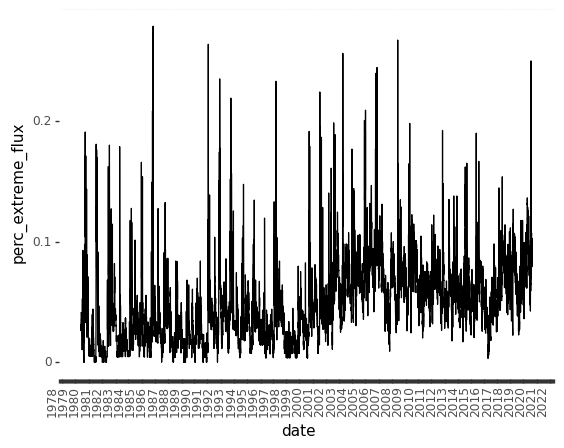

<ggplot: (157327163278)>

In [24]:
(ggplot(data = over_time2[over_time2['perc_extreme_flux'] < 1], 
        mapping = aes(x = 'date', y = 'perc_extreme_flux', group = 1)) +
    geom_line() + 
    scale_x_datetime(breaks=date_breaks('1 month'),
                     labels=custom_date_format) +
    theme(axis_text_x=element_text(rotation=90, hjust=1)))

Yes. The flux has increased over time. The minimum of the serie from 2003 has increased by the image above, even with its seasonality over time. Also, we can see every year there is a peak for percentage of extreme flux.

### Modeling

For this modeling exercise, since we have different extreme flux by season, we could develop 1 model that captures its seasonality and trends over time. Since we want to detect previously an extreme event, it would be necessary to predict in advance when its going to happen. For better results, we could try to split the database by station (or a group of similar stations - locality, percentage of extreme events, so on).

We are going to use a package called 'prophet' from Meta. It is used to predict timeseries forecasting and uses a generalized additive model (GAM), a class of regression models with potentially non-linear smoothers applied to the regressors. Also, this model can be very intuitive and easy to manage its parameters. The only variables necessary for this exercise will be 'date' and 'flux'.

In [25]:
df2['date'].max()

'2020-06-06'

In [26]:
df2['date'].min()

'1980-01-01'

Since we have dates from 1980-01-01 to 2020-06-06 (aprox. 40 years), we are going to use it all to build the model and check performance in the end using cross validation through time.

In [58]:
df_to_predict = df2[['date', 'flux']].rename(columns={"date":"ds", "flux":"y"})
# df_to_predict = df_to_predict[pd.to_datetime(df_to_predict['ds']) >= pd.to_datetime('2000-01-01')] # selecting dates 

Let's also aggregate the data by date and take the max 'flux' for each one so we can build a dataframe to predict. Since it's an unique variable in the timeseries, we do not need to scale.

In [59]:
df_to_predict2 = pd.DataFrame(df_to_predict.groupby('ds')['y'].max()).reset_index()
df_to_predict2

,ds,y
0,1980-01-01,373.000
1,1980-01-02,353.000
2,1980-01-03,342.000
3,1980-01-04,337.000
4,1980-01-05,338.000
...,...,...
14763,2020-06-02,842.739
14764,2020-06-03,828.151
14765,2020-06-04,946.610
14766,2020-06-05,1712.100


In [60]:
# Fitting the model

# Cut off the data after 2015 to use as our validation set. We will train on earlier data.

m = Prophet().fit(df_to_predict2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [61]:
future = m.make_future_dataframe(periods=365) # train df + 1 year
future

,ds
0,1980-01-01
1,1980-01-02
2,1980-01-03
3,1980-01-04
4,1980-01-05
...,...
15128,2021-06-02
15129,2021-06-03
15130,2021-06-04
15131,2021-06-05


In [70]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,ds,yhat,yhat_lower,yhat_upper
0,1980-01-01,254.304676,-833.058280,1247.359062
1,1980-01-02,258.488429,-800.373740,1492.319954
2,1980-01-03,243.893785,-793.973455,1292.047349
3,1980-01-04,240.371353,-834.222636,1275.427889
4,1980-01-05,244.593055,-791.658146,1304.172708
...,...,...,...,...
15128,2021-06-02,1548.039135,601.985945,2695.826721
15129,2021-06-03,1546.496054,585.002484,2612.144940
15130,2021-06-04,1555.405695,523.122899,2537.391634
15131,2021-06-05,1571.594178,505.809550,2670.266857


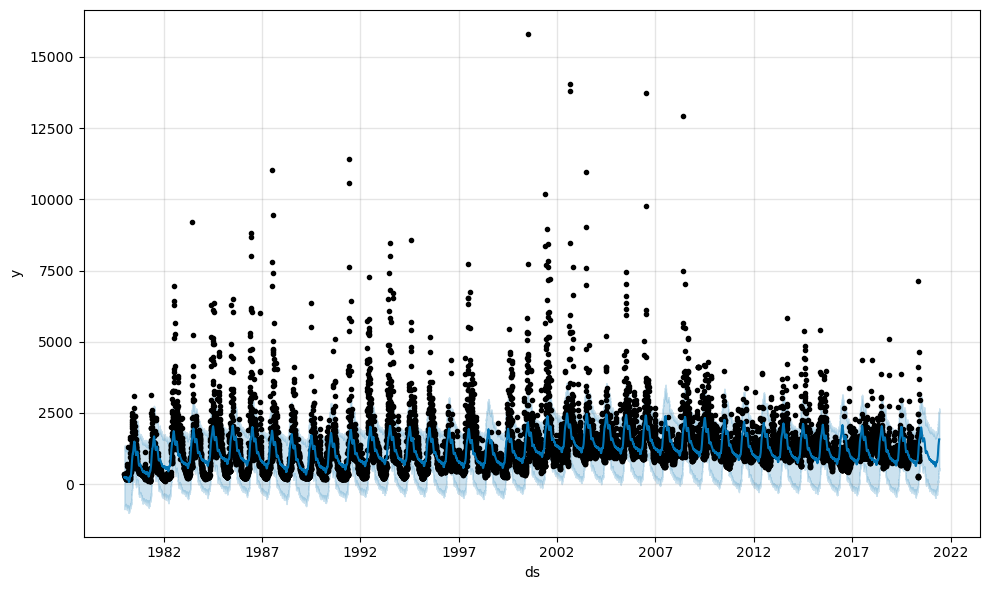

In [63]:
fig1 = m.plot(forecast)

We could detect, for example, extreme flux data if the predicted value is over yhat_upper.

Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible. (figure below)

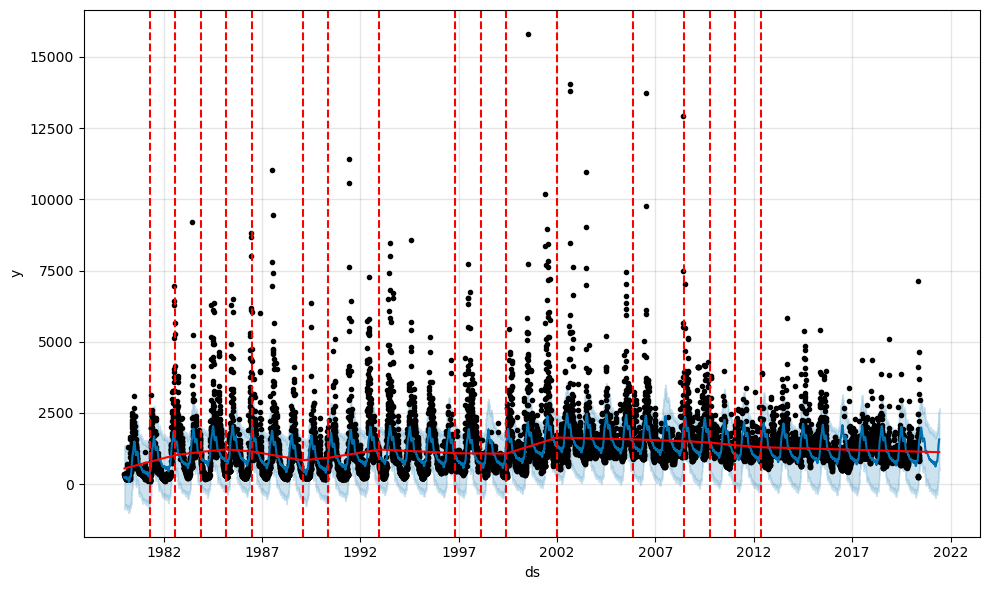

In [64]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


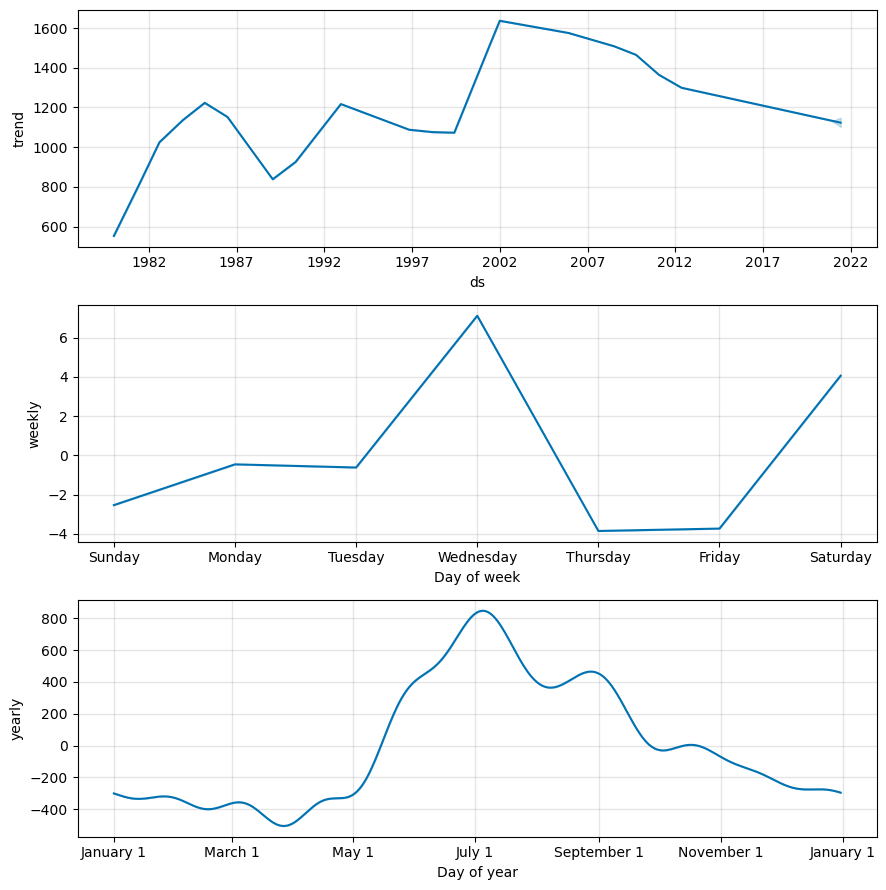

In [65]:
fig2 = m.plot_components(forecast)

#### Cross Validation

Starting with a initial series of 3600 days (10 years) to train and making predictions to the next 365 days (1 year) with a rolling window of 365 days (1 year).

The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors. In this case we are not using extra regressors.

Making 30 forecasts with cutoffs between 1990-06-14 and 2019-06-07 so we can evaluate the predictions through time.

In [66]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='3600 days', period='365 days', horizon = '365 days')

INFO:prophet:Making 30 forecasts with cutoffs between 1990-06-14 00:00:00 and 2019-06-07 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\mateus.a.florentino\Anaconda3\envs\test\lib\site-packages\prophet\forecaster.py:896

In [67]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1990-06-15,1495.164625,648.962864,2422.985084,1264.000,1990-06-14
1,1990-06-16,1503.102121,636.082694,2460.675714,1167.000,1990-06-14
2,1990-06-17,1485.217384,544.631614,2370.624537,1117.000,1990-06-14
3,1990-06-18,1490.748705,607.003937,2424.915522,1050.000,1990-06-14
4,1990-06-19,1502.382834,564.459930,2381.671325,1098.000,1990-06-14
...,...,...,...,...,...,...
10945,2020-06-02,1565.107717,612.087108,2659.322664,842.739,2019-06-07
10946,2020-06-03,1584.818973,670.751587,2608.652440,828.151,2019-06-07
10947,2020-06-04,1584.822119,558.609359,2618.262434,946.610,2019-06-07
10948,2020-06-05,1592.249938,553.835221,2597.655937,1712.100,2019-06-07


##### Evaluating Cross Validation

In [69]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,2.059699e+06,1435.165022,1029.241754,0.747155,0.511692,0.501580,0.589954
1,38 days,2.105926e+06,1451.180785,1043.036822,0.751068,0.518196,0.505751,0.586758
2,39 days,2.143831e+06,1464.182626,1051.302920,0.751851,0.521383,0.507757,0.585845
3,40 days,2.166285e+06,1471.830389,1054.939761,0.752353,0.530596,0.508724,0.584018
4,41 days,2.186398e+06,1478.647506,1060.536413,0.755029,0.535806,0.510803,0.582648
...,...,...,...,...,...,...,...,...
324,361 days,1.576949e+06,1255.766496,824.901334,0.812420,0.509228,0.529435,0.733333
325,362 days,1.607504e+06,1267.873792,841.746968,0.829664,0.521942,0.535345,0.723288
326,363 days,1.627673e+06,1275.802834,857.538618,0.847504,0.531560,0.541449,0.710502
327,364 days,1.640123e+06,1280.672998,868.594401,0.860094,0.533804,0.544948,0.701826


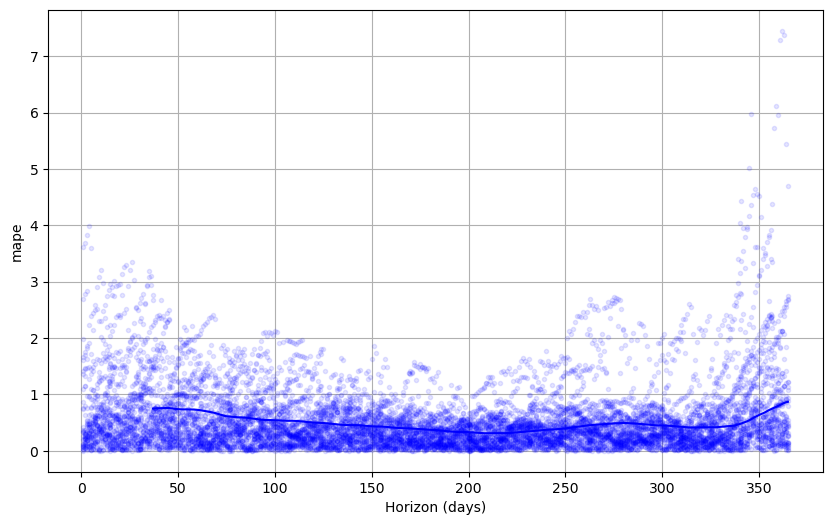

In [68]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors less than 0.5% are typical for predictions around six months into the future (when there are extreme values - we can see in the plot for yearly seasonality), and that errors increase up to around 1% for predictions that in a few months in the beginning and in a few months in the end of the predicted year. It looks like a very good model with minor erros to predict future extreme flux events.